# Union Investment - Financial Modeling of the Equity Market

# 0. Write Functions

In [62]:
def flatten(x):
    ''' 
    Creates a generator object that loops through a nested array.
  
    Parameters:
    ----------
    x - A nested array.

    Returns: 
    ----------
    j - A flattened array.
    '''
    
    # Check if the array is iterable
    try:
        narray = iter(x)
    # If it is not iterable return the array
    except TypeError:
        yield x
    # If it is iterable, loop through the array recursively
    else:
        for i in narray:
            for j in flatten(i):
                yield j

# 0. Load Libraries

In [63]:
# suppress future warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


import numpy as np

import pandas as pd

from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

import seaborn as sns


from imblearn.over_sampling import SMOTE


import statsmodels.api as sm

import sklearn

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.model_selection import PredefinedSplit

from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import ExtraTreesClassifier


from sklearn.feature_selection import RFE

import eli5

from eli5.sklearn import PermutationImportance



## Configurations
# display all columns
pd.set_option('display.max_columns', None)

# 1. Data

### Import 

In [64]:
# Import data
data_raw = pd.read_csv("Input_Data_for_Candidate.csv").set_index('Date')

# Change type of response variable
data_raw['Target'] = data_raw['Target'].astype('category')

# Change order of the columns
cols = data_raw.columns.tolist()
cols = cols[1:] + cols[0:1]
data_raw = data_raw[cols]

### Extract information 

In [65]:
# Show number of rows and columns
print("Rows, Columns:");print(data_raw.shape);print("\n")

# Show column names
print("Columns:");print(data_raw.columns);print("\n")

# Show info
print("Info:");print(data_raw.info()); print("\n")

# Count Non-NaNs per indicator
print("Non-NaN per indicator:");print(data_raw.count()); print("\n")

# Count NaNs per indicator
print("NaN per indicator:");print(data_raw.isna().sum());print("\n")

# Sum NaNs 
print("total NaN values: ", data_raw.isna().sum().sum(),'\n')

# Show head
print("Head");print(data_raw.head()); print("\n")

# Show tail
print("Tail");print(data_raw.tail());print("\n")

# Show summary statistics
print("Summary statistics:");print(data_raw.describe());print("\n")

Rows, Columns:
(15119, 28)


Columns:
Index(['Indikator1', 'Indikator2', 'Indikator3', 'Indikator4', 'Indikator5',
       'Indikator6', 'Indikator7', 'Indikator8', 'Indikator9', 'Indikator10',
       'Indikator11', 'Indikator12', 'Indikator13', 'Indikator14',
       'Indikator15', 'Indikator16', 'Indikator17', 'Indikator18',
       'Indikator19', 'Indikator20', 'Indikator21', 'Indikator22',
       'Indikator23', 'Indikator24', 'Indikator25', 'Indikator26',
       'Indikator27', 'Target'],
      dtype='object')


Info:
<class 'pandas.core.frame.DataFrame'>
Index: 15119 entries, 1960-01-04 to 2020-01-27
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Indikator1   15118 non-null  float64 
 1   Indikator2   15118 non-null  float64 
 2   Indikator3   15118 non-null  float64 
 3   Indikator4   15119 non-null  float64 
 4   Indikator5   15119 non-null  float64 
 5   Indikator6   15119 non-null  float64 
 6   Indikator

### NaNs

In [66]:
# Drop rows with NaNs
data = data_raw.dropna(how='any')

# Show shape of dataframe before removing NaNs
print("old dataframe shape: ", data_raw.shape)

# Show number of missing values
print("total NaN values: ", data_raw.isna().sum().sum(),'\n')

# Show shape of dataframe after removing NaNs
print("new dataframe shape: ", data.shape)

# Show number of missing values
print("total NaN values: ", data.isna().sum().sum(),'\n')

# Show how much data we lost 
print("--> we lost %s Non-NaN values;" %
      ((data_raw.shape[0]*data_raw.shape[1]) - (data.shape[0]*data.shape[1]) - data_raw.isna().sum().sum()), 'which corresponds to only', 
      np.round(np.multiply(np.divide(((data_raw.shape[0]*data_raw.shape[1]) - (data.shape[0]*data.shape[1]) + data.isna().sum().sum()),
      data_raw.shape[0]*data_raw.shape[1]),100),2), '% of our data')

old dataframe shape:  (15119, 28)
total NaN values:  20 

new dataframe shape:  (15117, 28)
total NaN values:  0 

--> we lost 36 Non-NaN values; which corresponds to only 0.01 % of our data


### Check whether data is balanced

In [67]:
# Show number of ups 
print("Number of ups",sum(data['Target']==1))

# Show % of ups 
print("Percentage of ups",np.round(sum(data['Target']==1)/data['Target'].count()*100), '%'); print("\n")

# Show number of downs 
print("Number of dows",sum(data['Target']==0))

# Show % of downs 
print("Percentage of downs",np.round(sum(data['Target']==0)/data['Target'].count()*100), '%')

Number of ups 7988
Percentage of ups 53.0 %


Number of dows 7129
Percentage of downs 47.0 %


### Visualizations

#### Indicator Distributions

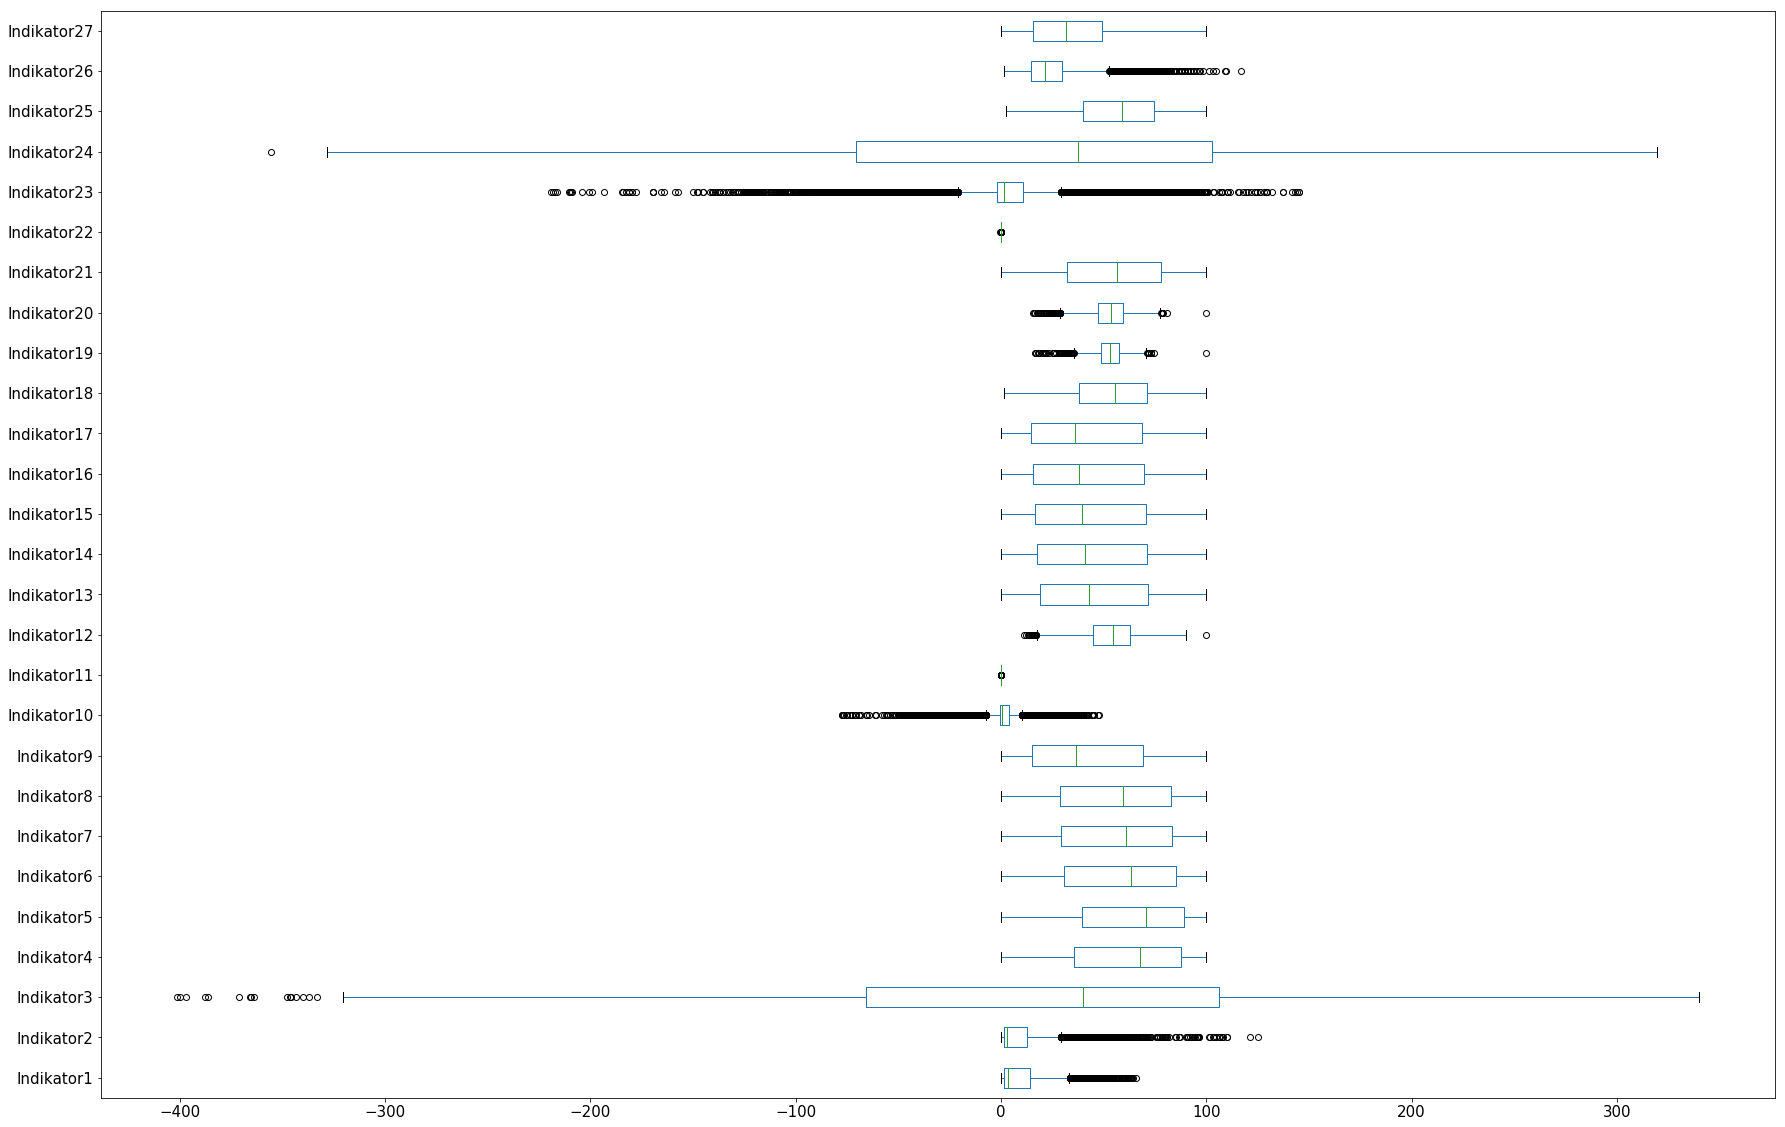

In [68]:
# Plot distributions of indicators 
data.plot.box(vert=False, figsize=(30,20), fontsize=15);

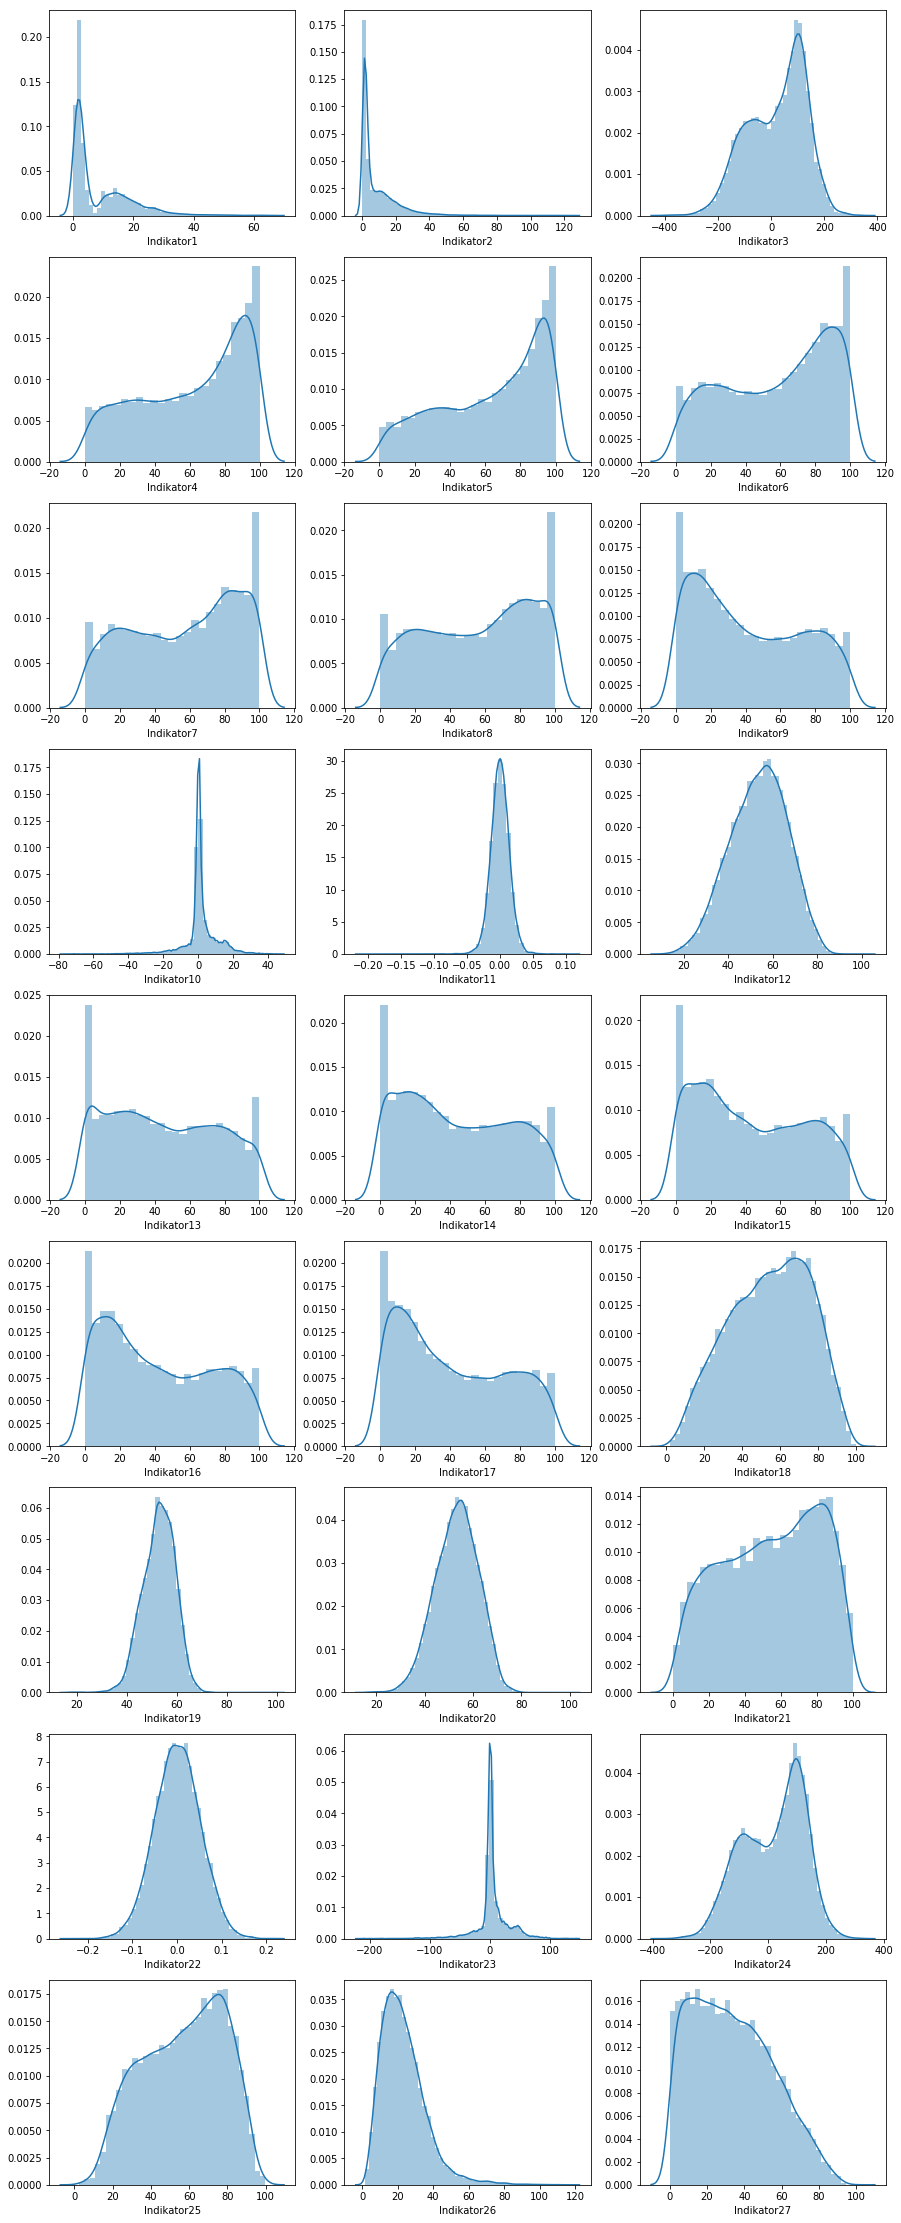

In [69]:
# Plot distributions of indicators 
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15,40))
for ax, col in zip(flatten(axes), data.iloc[:,:-1].columns):
    sns.distplot(data[col], ax=ax)

#### Indicator correlation matrix

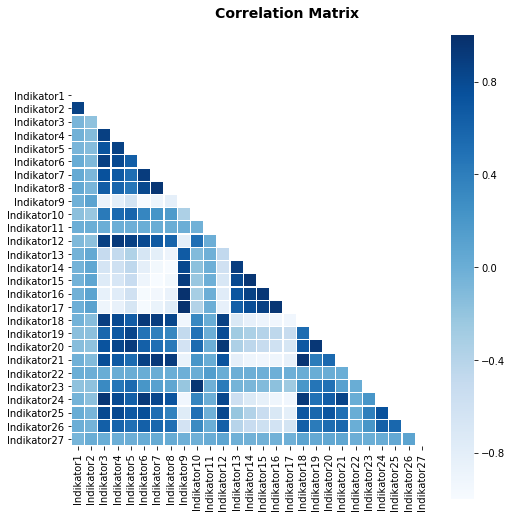

In [70]:
# Plot correlation matrix of indicators 
corr=data.iloc[:,0:27].corr()

mask=np.zeros_like(corr); mask[np.triu_indices_from(mask)]=True # we use mask to plot only part of the matrix

heat_fig, (ax)=plt.subplots(1, 1, figsize=(8,8))

heat=sns.heatmap(corr, 
                 ax=ax, 
                 mask=mask, 
                 vmax=1, 
                 square=True, 
                 linewidths=.2, 
                 cmap="Blues")

heat_fig.subplots_adjust(top=.93)

heat_fig.suptitle('Correlation Matrix', fontsize=14, fontweight='bold')

plt.savefig('heat1.eps', dpi=200, format='eps');

#### Indicator-Target Relationships

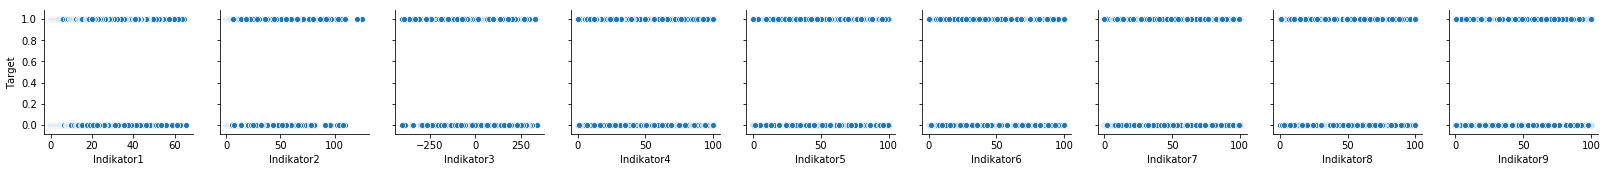

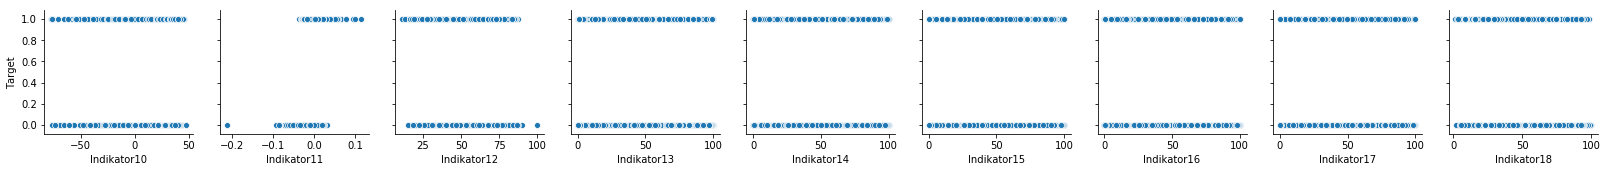

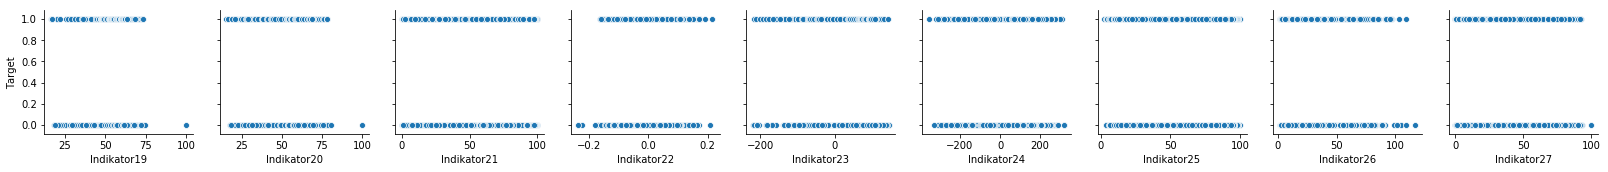

In [71]:
# Plot indicator-target Relationships
sns.pairplot(data=data,
             y_vars=['Target'],
             x_vars=data.iloc[:,0:9].columns);
sns.pairplot(data=data,
             y_vars=['Target'],
             x_vars=data.iloc[:,9:18].columns);
sns.pairplot(data=data,
             y_vars=['Target'],
             x_vars=data.iloc[:,18:27].columns);

### Define features and response variable

In this notebook, will consider the following:
1. Raw data

### Raw data

In [72]:
# Split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(data.iloc[:,:-1], 
                                                    data.iloc[:,-1], 
                                                    test_size=0.1, 
                                                    shuffle=False)

# 2. Random Forest

### Workflow

<img src="work-flow.png" width="800" />

Source: Own illustration

### Hyperparameter

Importtant Hyperparameters: 
1. Number of trees (n_estimators)
2. Number of features to consider at each split (max_features)
3. Deepth of the tree (min_samples_leaf, max_depth, min_samples_split, min_weight_fraction_leaf, max_leaf_nodes, min_impurity_decrease)

### Walk Forward Cross-Validation

Time Series cross-validator provides train/dev indices to split time series data samples that are observed at fixed time intervals, in train/dev sets. In each split, dev indices must be higher than before, and thus shuffling in cross validator is inappropriate. The following graph illustrates how the time series split works:


<img src="walk-forward.png" width="800" />

Source: Own illustration

### Configuration for Walk-forward validation

In [73]:
# Walk-forward validation
dev_size=0.1 
n_splits=int((1//dev_size)-1)   # using // for integer division
tscv=TimeSeriesSplit(n_splits=n_splits) 

# Print number of splits
print('we consider', n_splits, 'splits' )

we consider 8 splits


## 2.1 Raw data

### Fit Random Forest

In [74]:
# Set up Classifier
classifier_1 = RandomForestClassifier(random_state=1, 
                                      criterion="entropy", 
                                      bootstrap=False,
                                      verbose=0,
                                      n_jobs=-1)

# Set up parameter grid 
param_grid_1 = [{"n_estimators":[500],                   # number of trees in the forest
                 "max_features": ["sqrt"],               # number of features to consider for the best split
                 "min_samples_leaf":[0.01, 0.05, 0.1]}]  # minimum percentage of samples required to be at a leaf node     
        
# Set up gridsearch
rf_1 = GridSearchCV(classifier_1, 
                    param_grid=param_grid_1, 
                    cv=tscv, 
                    verbose=0, 
                    n_jobs=-1, 
                    scoring="accuracy", 
                    refit=True, 
                    return_train_score=False,
                    iid=False)
             
# Fit the Classifier
rf_1.fit(x_train, np.ravel(y_train))
        
# Save feature importance
rf_fs_avg_1 = pd.DataFrame(rf_1.best_estimator_.feature_importances_*100, 
                           columns=["Importance"]).set_index(x_train.columns)

### Feature importance average

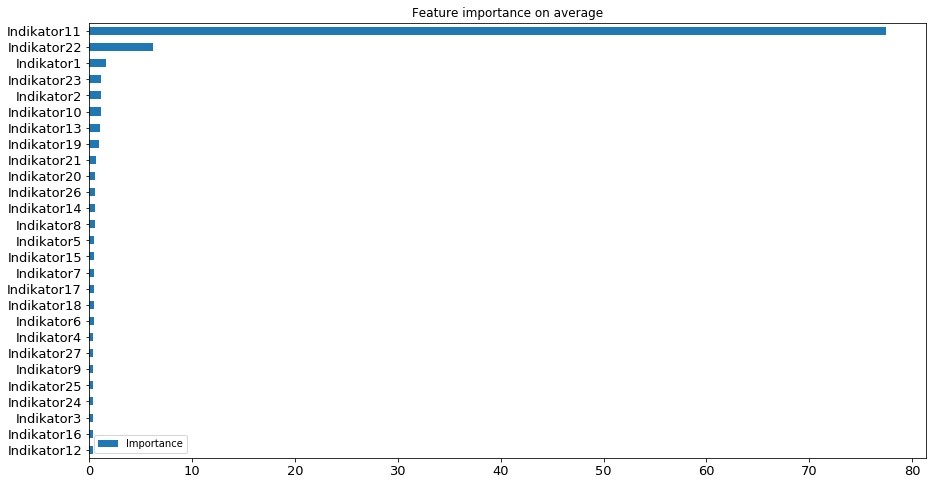

In [75]:
# Plot feature importance
rf_fs_avg_1.sort_values(ascending=True, axis=0, by='Importance').plot.barh(
figsize=[15,8],
fontsize=13,                                                              
title ="Feature importance on average");

### Perform Predictions 

In [76]:
# Perform predictions 
rf_pre_1 = rf_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, rf_pre_1))

Accuracy: 0.7003968253968254


### Confusion Matrix

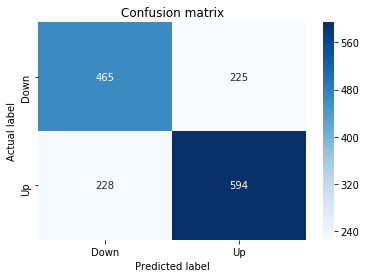

In [77]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, rf_pre_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']);ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [78]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, rf_pre_1))

              precision    recall  f1-score   support

         0.0       0.67      0.67      0.67       690
         1.0       0.73      0.72      0.72       822

    accuracy                           0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

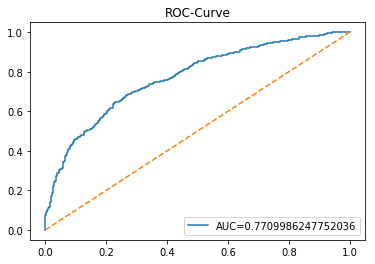

In [79]:
# Create Roc Curve
rf_prob_1 = rf_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_prob_1)
auc = metrics.roc_auc_score(y_test.values, rf_prob_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# 3. Random Forest - Over-sampling minority class (downs) 

### Over-sample minority class (downs)

In [80]:
# Set over-sampler
os = SMOTE(random_state=0)

# Fit over-sampler
x_train_os, y_train_os = os.fit_sample(x_train, y_train.values)

# Save over-sampled training data
x_train_os = pd.DataFrame(data=x_train_os,columns=x_train.columns)
y_train_os = pd.DataFrame(data=y_train_os, columns=['Target'])

# Verify over-sampling
print('Before Over-sampling:', )
print("Number of ups",np.sum(y_train==1))
print("Number of downs",np.sum(y_train==0));print("\n")

print('After Over-sampling:')
print("Number of ups",np.sum(y_train_os.values==1))
print("Number of downs",np.sum(y_train_os.values==0))

Before Over-sampling:
Number of ups 7166
Number of downs 6439


After Over-sampling:
Number of ups 7166
Number of downs 7166


## 3.1 Raw data

### Fit Random Forest

In [81]:
# Set up Classifier
classifier_os_1 = RandomForestClassifier(random_state=1, 
                                         criterion="entropy", 
                                         bootstrap=False,
                                         verbose=0,
                                         n_jobs=-1)

# Set up parameter grid 
param_grid_os_1 = [{"n_estimators":[500],                   # number of trees in the forest
                    "max_features": ["sqrt"],               # number of features to consider for the best split
                    "min_samples_leaf":[0.01, 0.05, 0.1]}]  # minimum percentage of samples required to be at a leaf node     
        
# Set up gridsearch
rf_os_1 = GridSearchCV(classifier_os_1, 
                       param_grid=param_grid_os_1, 
                       cv=tscv, 
                       verbose=0, 
                       n_jobs=-1, 
                       scoring="accuracy", 
                       refit=True, 
                       return_train_score=False,
                       iid=False)
             
# Fit the Classifier
rf_os_1.fit(x_train_os, np.ravel(y_train_os))
        
# Save feature importance
rf_fs_avg_os_1 = pd.DataFrame(rf_os_1.best_estimator_.feature_importances_*100, 
                              columns=["Importance"]).set_index(x_train.columns)

### Perform Predictions 

In [82]:
# Perform predictions
rf_pre_os_1 = rf_os_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, rf_pre_os_1))

Accuracy: 0.7023809523809523


### Confusion Matrix

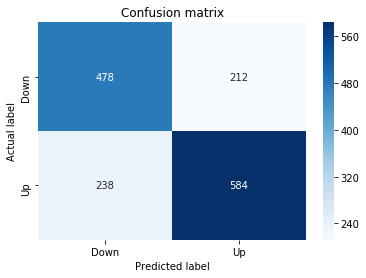

In [83]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, rf_pre_os_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']);ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [84]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, rf_pre_os_1))

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68       690
         1.0       0.73      0.71      0.72       822

    accuracy                           0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

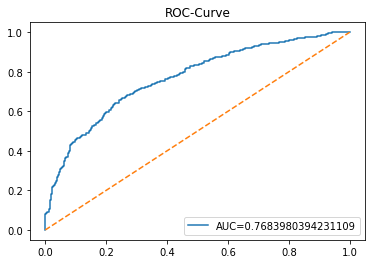

In [85]:
# Create Roc Curve
rf_prob_os_1 = rf_os_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_prob_os_1)
auc = metrics.roc_auc_score(y_test.values, rf_prob_os_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# 4. Random Forest - Feature Selection

### Configuration of the necessary steps

In [86]:
# Set up Classifier
clf = RandomForestClassifier(random_state=1, 
                             criterion="entropy", 
                             bootstrap=False,
                             verbose=0,
                             n_jobs=-1,
                             n_estimators=500,          # number of trees in the forest
                             max_features="sqrt",       # number of features to consider for the best split
                             min_samples_leaf=0.008)    # minimum percentage of samples required to be at a leaf node

# Set up Selector
selector = SelectFromModel(clf)

# Define steps
steps = [('feat_selection',selector),
         ('clf', clf)]

# Set up pipeline
pipeline = Pipeline(steps)

## 4.1. Raw data 

### Fit Random Forest Model 

In [87]:
# Set up parameter grid 
param_grid_1 = dict(feat_selection__threshold=[0.04, 0.06, 0.08, 0.1])

# Set up Gridsearch
rf_fs_1 = GridSearchCV(estimator=pipeline, 
          param_grid=param_grid_1, 
          cv=tscv, 
          verbose=0, 
          n_jobs=-1, 
          scoring="accuracy", 
          refit=True, 
          return_train_score=False,
          iid=False)

# Fit the Classifier
rf_fs_1.fit(x_train, np.ravel(y_train))

# Print number and list of selected features
print("Num indicators: %s" % (rf_fs_1.best_estimator_.steps[0][1].get_support().sum()))
print("Selected indicators: %s" % (x_train.iloc[:,rf_fs_1.best_estimator_.steps[0][1].get_support()].columns.tolist()),'\n''\n')

Num indicators: 2
Selected indicators: ['Indikator11', 'Indikator22'] 




### Perform Predictions

In [117]:
# Perform predictions
rf_pre_fs_1 = rf_fs_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, rf_pre_fs_1))

Accuracy: 0.6977513227513228


### Confusion Matrix

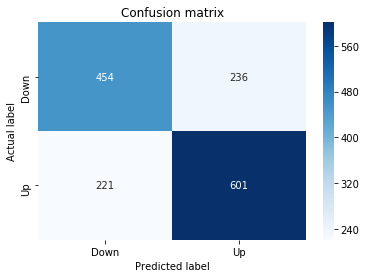

In [118]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, rf_pre_fs_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']);ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [119]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, rf_pre_fs_1))

              precision    recall  f1-score   support

         0.0       0.67      0.66      0.67       690
         1.0       0.72      0.73      0.72       822

    accuracy                           0.70      1512
   macro avg       0.70      0.69      0.69      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

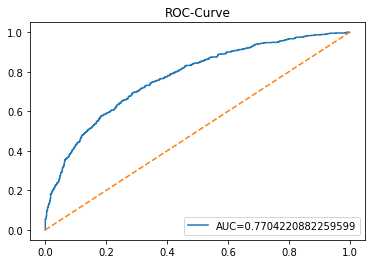

In [120]:
# Create Roc Curve
rf_prob_fs_1 = rf_fs_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_prob_fs_1)
auc = metrics.roc_auc_score(y_test.values, rf_prob_fs_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# 5. Random Forest - Feature Selection for Over-sampling minority class 

### Fit Random Forest Model 

In [99]:
# Set up parameter grid 
param_grid_1 = dict(feat_selection__threshold=[0.04, 0.06, 0.08, 0.1])

# Set up Gridsearch
rf_os_fs_1 = GridSearchCV(estimator=pipeline, 
             param_grid=param_grid_1, 
             cv=tscv, 
             verbose=0, 
             n_jobs=-1, 
             scoring="accuracy", 
             refit=True, 
             return_train_score=False,
             iid=False)

# Fit the Classifier
rf_os_fs_1.fit(x_train_os, np.ravel(y_train_os))

# Print number and list of selected features
print("Num indicators: %s" % (rf_os_fs_1.best_estimator_.steps[0][1].get_support().sum()))

print("Selected indicators: %s" % (x_train.iloc[:,rf_os_fs_1.best_estimator_.steps[0][1].get_support()].columns.tolist()),'\n''\n')

Num indicators: 2
Selected indicators: ['Indikator11', 'Indikator22'] 




### Perform Predictions

In [100]:
# Perform predictions
rf_pre_os_fs_1 = rf_os_fs_1.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test, rf_pre_os_fs_1))

Accuracy: 0.7023809523809523


### Confusion Matrix

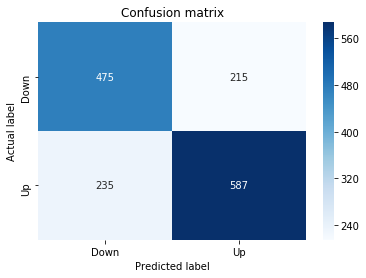

In [114]:
# Create confustion matrix
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(y_test, rf_pre_os_fs_1)), annot=True, cmap="Blues" ,fmt='g')
plt.title('Confusion matrix'); plt.ylabel('Actual label'); plt.xlabel('Predicted label')
ax.xaxis.set_ticklabels(['Down', 'Up']);ax.yaxis.set_ticklabels(['Down', 'Up']);

### precision, recall, F-measure and support

In [115]:
# Compute precision, recall, F-measure and support
print(classification_report(y_test, rf_pre_os_fs_1))

              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68       690
         1.0       0.73      0.71      0.72       822

    accuracy                           0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70      1512



### Roc Curve

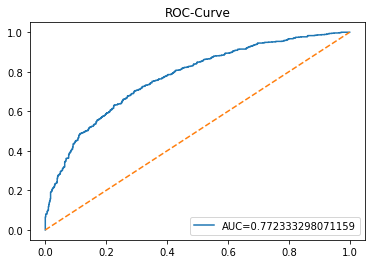

In [116]:
# Create Roc Curve
rf_prob_os_fs_1 = rf_os_fs_1.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, rf_prob_os_fs_1)
auc = metrics.roc_auc_score(y_test.values, rf_prob_os_fs_1)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.plot([0, 1], [0, 1], linestyle='--') # plot no skill
plt.title('ROC-Curve')
plt.show()

# Permutation importance (model agnostic)

Documentation: https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

We can check the feature importance (with respect to the training or test sets) for any estimator that has already been fitted 

### Example 1:  model *rf_1* 

In [97]:
perm = PermutationImportance(rf_1).fit(x_train, y_train)
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.2133 ± 0.0079,Indikator11
0.0109 ± 0.0019,Indikator22
0.0056 ± 0.0014,Indikator13
0.0047 ± 0.0006,Indikator1
0.0036 ± 0.0006,Indikator2
0.0033 ± 0.0012,Indikator19
0.0030 ± 0.0011,Indikator23
0.0028 ± 0.0008,Indikator14
0.0028 ± 0.0012,Indikator21
0.0028 ± 0.0010,Indikator10


**--> Similar to the feature selection of random forest, we could:**

1. Use the validation set approach, to find the optimal threshold (weight)
2. Use the selected (weights > threshold) indicators to fit a model on training and validation data
3. Perform predictions on the test data

### Example 2: model *rf_os_1* 

In [98]:
perm = PermutationImportance(rf_os_1).fit(x_train_os, y_train_os.values.ravel())
eli5.show_weights(perm, feature_names = x_train.columns.tolist())

Weight,Feature
0.2256 ± 0.0061,Indikator11
0.0088 ± 0.0026,Indikator22
0.0061 ± 0.0020,Indikator13
0.0049 ± 0.0010,Indikator1
0.0039 ± 0.0012,Indikator21
0.0036 ± 0.0009,Indikator2
0.0031 ± 0.0008,Indikator19
0.0027 ± 0.0008,Indikator10
0.0027 ± 0.0013,Indikator8
0.0027 ± 0.0009,Indikator23


**--> Similar to the feature selection of random forest, we could:**

1. Use the validation set approach, to find the optimal threshold (weight)
2. Use the selected (weights > threshold) indicators to fit a model on training and validation data
3. Perform predictions on the test data